<a href="https://colab.research.google.com/github/jamiewell/python_DataAnalysis/blob/master/python_ML/titanic_survival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install kaggle

In [0]:
#from google.colab import files
#files.upload()

In [0]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
ls -1ha kaggle.json

kaggle.json


In [0]:
!mkdir -p ~/.kaggle

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
#!ls -al

In [0]:
#!kaggle competitions list

In [10]:
!kaggle competitions download -c titanic

  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.50MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 61.5MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 25.1MB/s]


In [11]:
!ls

gender_submission.csv  kaggle.json  sample_data  test.csv  train.csv


In [0]:
# EDA without Scikit learn

In [0]:
titanic_df = pd.read_csv('./train.csv')

In [16]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [17]:
titanic_df.shape

(891, 12)

In [18]:
print(""" Titanic Data Info """)
print(titanic_df.info())

 Titanic Data Info 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [19]:
total = titanic_df.isnull().sum().sum()
print(""" Test Data Set: NULL Count {} """.format(total))

 Test Data Set: NULL Count 866 


In [20]:
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [0]:
# Null값 처리
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
titanic_df['Cabin'].fillna('N', inplace=True)
titanic_df['Embarked'].fillna('N', inplace=True) 

In [22]:
titanic_df['Sex'].value_counts().reset_index()

,index,Sex
0,male,577
1,female,314


In [23]:
titanic_df['Cabin'].value_counts()

N              687
G6               4
C23 C25 C27      4
B96 B98          4
E101             3
              ... 
B50              1
B4               1
C85              1
A16              1
A36              1
Name: Cabin, Length: 148, dtype: int64

In [24]:
# 영문 문자열만 사용
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
titanic_df['Cabin'].head(10)

0    N
1    C
2    N
3    C
4    N
5    N
6    E
7    N
8    N
9    N
Name: Cabin, dtype: object

In [25]:
titanic_df['Embarked'].value_counts().reset_index()

,index,Embarked
0,S,644
1,C,168
2,Q,77
3,N,2


In [26]:
titanic_df.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

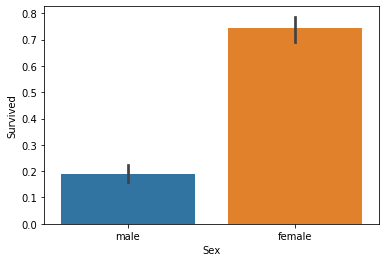

In [27]:
sns.barplot(x='Sex', y='Survived',data=titanic_df)

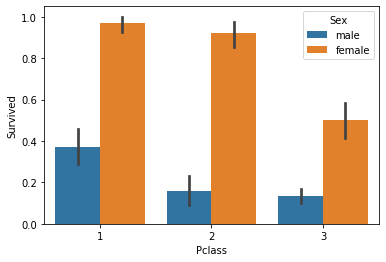

In [28]:
sns.barplot(x='Pclass', y='Survived', hue='Sex' ,data=titanic_df)

In [0]:
#연령별 카테고리화 함수
def getCategory(age):
  category = ''
  if age <= -1: category = 'Unknown'
  elif age <= 5: category = 'Baby'
  elif age <= 12: category = 'Child'
  elif age <= 18: category = 'Teenager'
  elif age <= 25: category = 'Student'
  elif age <= 35: category = 'Young Adult'
  elif age <= 60: category = 'Adult'
  else : category = 'Elderly'

  return category 

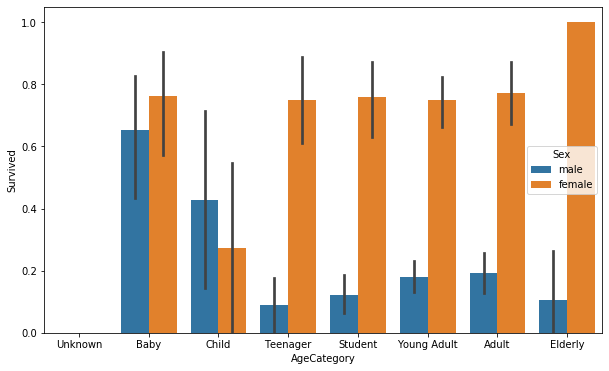

In [31]:
plt.figure(figsize=(10,6))
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

# 연령구간으로 카테고리화
titanic_df['AgeCategory'] = titanic_df['Age'].apply(lambda x : getCategory(x))
sns.barplot(x='AgeCategory', y='Survived', hue='Sex', data=titanic_df, order=group_names)
titanic_df.drop('AgeCategory', axis=1, inplace=True)

In [0]:
# 레이블 인코딩
def encodeFeatures(dataDF):
  features = ['Cabin','Sex','Embarked']
  for feature in features:
    le = preprocessing.LabelEncoder()
    le = le.fit(dataDF[feature])
    dataDF[feature] = le.transform(dataDF[feature])

  return dataDF     

In [51]:
titanic_df = encodeFeatures(titanic_df)
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3


In [0]:
# Null 처리 함수
def fillNa(dataDF):
  dataDF['Age'].fillna(dataDF['Age'].mean(), inplace=True)
  dataDF['Cabin'].fillna('N', inplace=True)
  dataDF['Embarked'].fillna('N', inplace=True)
  dataDF['Fare'].fillna(0, inplace=True)
  return dataDF

In [0]:
# ML 불필요 속성 제거
def dropFeatures(dataDF):
  dataDF.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)
  return dataDF

In [0]:
# 레이블 인코딩
def formatFeatures(dataDF):
  dataDF['Cabin'] = dataDF['Cabin'].str[:1]
  features=['Cabin','Sex','Embarked']
  for feature in features:
    le = LabelEncoder()
    le = le.fit(dataDF[feature])
    dataDF[feature] = le.transform(dataDF[feature])
  return dataDF   

In [0]:
# Data preprocessing 함수 호출
def transformFeatures(dataDF):
  dataDF = fillNa(dataDF)
  dataDF = dropFeatures(dataDF)
  dataDF = formatFeatures(dataDF)
  return dataDF

In [0]:
# Use Scikit-Learn

In [0]:
titanicDF = pd.read_csv('./train.csv')
Y_titanicDF = titanicDF['Survived']
X_titanicDF = titanicDF.drop('Survived', axis=1)

In [0]:
X_titanicDF = transformFeatures(X_titanicDF)

In [0]:
# Train , Test Set 분리
X_train, X_test, Y_train, Y_test = train_test_split(X_titanicDF, Y_titanicDF, test_size=0.2, random_state=11)

In [41]:
# DT, RF LR 호출: sklearn의 classfier
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()

# DecisionTreeClassifier
dt_clf.fit(X_train, Y_train)
dt_pred = dt_clf.predict(X_test)
dt_acc = accuracy_score(Y_test, dt_pred)
print(' DecisionTreeClassifier accuracy : {0:.4f}'.format(dt_acc))

# RandomForestClassifier
rf_clf.fit(X_train, Y_train)
rf_pred = rf_clf.predict(X_test)
rf_acc = accuracy_score(Y_test,rf_pred)
print(' RandomForestClassifier accuracy : {0:.4f}'.format(rf_acc))

# LogisticRegression
#lr_clf.fit(X_train, Y_train)
#lr_pred = lr_clf.predict(X_test)
#lr_acc = accuracy_score(Y_test, lr_acc)
#print(' LogisticRegression accuracy : {0:.4f}'.format(lr_acc))

 DecisionTreeClassifier accuracy : 0.7877
 RandomForestClassifier accuracy : 0.8547


In [0]:
def execKfold(clf, folds=5):
  kfold = KFold(n_splits=folds)
  scores = []

  #KFold 교차 검증
  for iterCount, (train_index, test_index) in enumerate(kfold.split(X_titanicDF)):
    X_train, X_test = X_titanicDF.values[train_index], X_titanicDF.values[test_index]
    Y_train, Y_test = Y_titanicDF.values[train_index], Y_titanicDF.values[test_index]

    clf.fit(X_train, Y_train)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(Y_test, predictions)
    print('K Fold {0} accuracy {1:.4f}'.format(iterCount, accuracy))
  
  # 평균 정확도
  mean_score = np.mean(scores)
  print('Mean accuracy: {0:.4f}'.format(mean_score))  

In [43]:
execKfold(dt_clf, folds=5)

K Fold 0 accuracy 0.7542
K Fold 1 accuracy 0.7809
K Fold 2 accuracy 0.7865
K Fold 3 accuracy 0.7697
K Fold 4 accuracy 0.8202
Mean accuracy: nan


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [44]:
execKfold(rf_clf, folds=5)

K Fold 0 accuracy 0.7933
K Fold 1 accuracy 0.8090
K Fold 2 accuracy 0.8371
K Fold 3 accuracy 0.7753
K Fold 4 accuracy 0.8596
Mean accuracy: nan


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [47]:
from sklearn.model_selection import GridSearchCV

parameters = { 'max_depth':[2,3,5,10],
               'min_samples_split':[2,3,5],
               'min_samples_leaf':[1,5,8]}

grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy', cv=5)
grid_dclf.fit(X_train, Y_train)

print('GridSearchCV Optimized Hyper Parameter', grid_dclf.best_params_)
print('GridSearchCV Best Accuracy: {0:.4f}'. format(grid_dclf.best_score_) )
best_dclf = grid_dclf.best_estimator_


dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(Y_test, dpredictions)
print('DecisionTree Classifier`s Accuracy on the Test set: {0:.4f}'.format(accuracy))


GridSearchCV Optimized Hyper Parameter {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV Best Accuracy: 0.7992
DecisionTree Classifier`s Accuracy on the Test set: 0.8715


In [50]:
parameters = { 'max_depth':[2,3,5,10],
               'min_samples_split':[2,3,5],
               'min_samples_leaf':[1,5,8]}

grid_dclf = GridSearchCV(rf_clf, param_grid=parameters, scoring='accuracy', cv=5)
grid_dclf.fit(X_train, Y_train)

print('GridSearchCV Optimized Hyper Parameter', grid_dclf.best_params_)
print('GridSearchCV Best Accuracy: {0:.4f}'. format(grid_dclf.best_score_) )
best_dclf = grid_dclf.best_estimator_


dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(Y_test, dpredictions)
print('Random Forest`s Accuracy on the Test set: {0:.4f}'.format(accuracy))


GridSearchCV Optimized Hyper Parameter {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
GridSearchCV Best Accuracy: 0.8146
Random Forest`s Accuracy on the Test set: 0.8827
